# I. Data Exploration

In [1]:
dataset_path = "./datasets/ATMA-V/"

In [2]:
import cv2

def get_frame_size(video_path):
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    height, width, _ = image.shape
    vidcap.release()
    return width, height

In [3]:
def get_all_vid_info():
    label_path = f"{dataset_path}/labels/labels.txt"
    vid_info = {} # key: file_name, value: (total_frame, frame_rate, ,width, height, anomaly, anomaly_span, number_of_anomaly, total_anomaly_length)
    with open(label_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            columns = line.strip().split()
            if len(columns) == 0:
                continue

            vid_name = columns[0]
            total_frame = int(columns[1])
            frame_rate = int(columns[2])
            w, h = get_frame_size(f"{dataset_path}/videos/og/{vid_name}")

            if "-1" in columns:
                vid_info[vid_name] = (total_frame, frame_rate, w, h, False, [], 0, 0)
            else:
                all_anomaly = []
                for i in range(3, len(columns), 2):
                    anomaly_span = (int(columns[i]), int(columns[i+1]))
                    all_anomaly.append(anomaly_span)
                total_anomaly_length = 0
                for span in all_anomaly:
                    total_anomaly_length += span[1] - span[0]
                vid_info[vid_name] = (total_frame, frame_rate, w, h, True, all_anomaly, len(all_anomaly), total_anomaly_length)

    return vid_info

vid_info = get_all_vid_info()

In [4]:
import pandas as pd

vid_df = pd.DataFrame.from_dict(vid_info, orient="index").reset_index()
vid_df.columns = ["file_name", "total_frame", "frame_rate", "width", "height", "anomaly", "anomaly_span", "number_of_anomaly", "total_anomaly_length"]
vid_df

,file_name,total_frame,frame_rate,width,height,anomaly,anomaly_span,number_of_anomaly,total_anomaly_length
0,3.mp4,737,30,290,284,True,"[(1, 737)]",1,736
1,5.mp4,1862,25,640,360,True,"[(160, 1862)]",1,1702
2,10.mp4,1796,30,440,360,True,"[(349, 1796)]",1,1447
3,11.mp4,297,24,640,360,True,"[(210, 297)]",1,87
4,12.mp4,910,24,640,360,False,[],0,0
...,...,...,...,...,...,...,...,...,...
60,88.mp4,1173,30,1078,718,True,"[(1, 1173)]",1,1172
61,89.mp4,3058,30,320,240,True,"[(707, 2915)]",1,2208
62,90.mp4,2081,25,854,326,True,"[(199, 2081)]",1,1882
63,92.mp4,588,6,352,288,True,"[(225, 340)]",1,115


In [5]:
vid_df.describe()

,total_frame,frame_rate,width,height,number_of_anomaly,total_anomaly_length
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,1030.261538,26.400000,672.153846,393.969231,0.769231,574.692308
std,1167.555048,6.191728,239.231140,121.378279,0.765858,952.925412
min,77.000000,6.000000,290.000000,220.000000,0.000000,0.000000
25%,378.000000,24.000000,640.000000,360.000000,0.000000,0.000000
50%,684.000000,25.000000,640.000000,360.000000,1.000000,117.000000
75%,1030.000000,25.000000,640.000000,360.000000,1.000000,607.000000
max,7558.000000,60.000000,1280.000000,720.000000,4.000000,5480.000000


In [6]:
print(f"Number of anomaly videos: {vid_df[vid_df['anomaly'] == True].shape[0]}")
print(f"Number of non-anomaly videos: {vid_df[vid_df['anomaly'] == False].shape[0]}")

Number of anomaly videos: 41
Number of non-anomaly videos: 24


# II. Data Preprocessing

## 1. Extract anomaly and non-anomaly videos

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

original_video_path = f"{dataset_path}/videos/og"
anomaly_path = f"{dataset_path}/videos/train/BT"
not_anomaly_path = f"{dataset_path}/videos/train/KBT"
test_path = f"{dataset_path}/videos/test"

In [8]:
# Train test split
def train_test_split_with_ratio(df, test_size=0.2, random_state=42):
    # Split the data while retaining the anomaly to non-anomaly ratio
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['anomaly'])
    return train_df, test_df

# Apply the function to your DataFrame
train_df, test_df = train_test_split_with_ratio(vid_df)

# Verify the split
print(f"Train set: {train_df.shape[0]} samples")
print(f"Test set: {test_df.shape[0]} samples")
print(f"Anomaly ratio in train set: {train_df['anomaly'].mean()}")
print(f"Anomaly ratio in test set: {test_df['anomaly'].mean()}")

Train set: 52 samples
Test set: 13 samples
Anomaly ratio in train set: 0.6346153846153846
Anomaly ratio in test set: 0.6153846153846154


In [9]:
# copy training videos
for idx, row in train_df.iterrows():
    vid_name = row["file_name"]
    anomaly = row["anomaly"]
    if anomaly:
        shutil.copy(f"{original_video_path}/{vid_name}", f"{anomaly_path}/{vid_name}")
    else:
        shutil.copy(f"{original_video_path}/{vid_name}", f"{not_anomaly_path}/{vid_name}")

# copy test videos
for idx, row in test_df.iterrows():
    vid_name = row["file_name"]
    shutil.copy(f"{original_video_path}/{vid_name}", f"{test_path}/{vid_name}")

## 2. Video standardization

- Resize video to 224x224
- Histogram equalization

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess

In [11]:
def extract_first_frame(video_path):
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    height, width, _ = image.shape
    vidcap.release()
    return image, (width, height)

def extract_all_frames(video_path):
    vidcap = cv2.VideoCapture(video_path)
    frames = []
    success, image = vidcap.read()
    height, width, _ = image.shape
    while success:
        frames.append(image)
        success, image = vidcap.read()
    vidcap.release()
    return frames, (width, height)

def create_video(frames, output_folder, vid_name, frame_rate, width, height):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(f"{output_folder}/{vid_name}", fourcc, frame_rate, (width, height))
    for frame in frames:
        video.write(frame)
    video.release()

In [19]:
def resize(frames, width, height):
    new_frames = []
    for i, frame in enumerate(frames):
        new_frame = cv2.resize(frame, (width, height))
        new_frames.append(new_frame)
    return new_frames

def histogram_equalization(frames):
    new_frames = []
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    for frame in frames:
        img_yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        new_frame = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        new_frames.append(new_frame)
    return new_frames

def denoise(frames):
    new_frames = []
    for frame in frames:
        new_frame = cv2.fastNlMeansDenoisingColored(frame, None, 8, 8, 7, 21)
        new_frames.append(new_frame)
    return new_frames

def frame_rate_standardization(vid_path, frame_rate):
    vid_folder = os.path.dirname(vid_path)
    vid_name_no_ext = os.path.splitext(os.path.basename(vid_path))[0]
    tmp_vid = os.path.join(vid_folder, f"{vid_name_no_ext}-tmp.mp4")
    command = f"ffmpeg -i {vid_path} -filter:v fps={frame_rate} {tmp_vid}"

    subprocess.run(command, shell=True)
    os.remove(vid_path)
    os.rename(tmp_vid, vid_path)

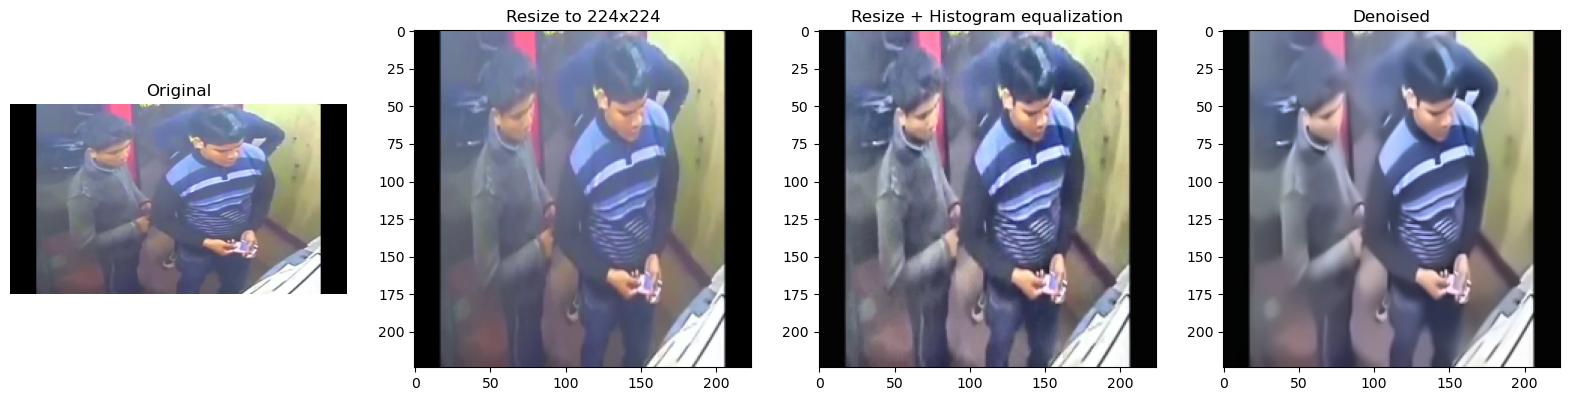

In [20]:
def standardize_preview():
    vid_name = "87.mp4"
    frames = [extract_first_frame(f"{original_video_path}/{vid_name}")[0]]

    # Plot original frame and standardized frames after each standardization
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original")
    ax[0].axis("off")

    # Resize
    rs_frames = resize(frames, 224, 224)
    ax[1].imshow(cv2.cvtColor(rs_frames[0], cv2.COLOR_BGR2RGB))
    ax[1].set_title("Resize to 224x224")

    # Histogram equalization
    he_frames = histogram_equalization(rs_frames)
    ax[2].imshow(cv2.cvtColor(he_frames[0], cv2.COLOR_BGR2RGB))
    ax[2].set_title("Resize + Histogram equalization")

    denoise_frames = denoise(he_frames)
    ax[3].imshow(cv2.cvtColor(denoise_frames[0], cv2.COLOR_BGR2RGB))
    ax[3].set_title("Denoised")

    plt.show()

standardize_preview()

In [14]:
# Standardize all training videos with multiprocessing
from multiprocessing import Pool, cpu_count

def standardize_video(row, new_frame_rate=24):
    vid_name = row["file_name"]
    new_width, new_height = 224, 224
    old_frame_rate = row["frame_rate"]
    anomaly = row["anomaly"]
    folder_path = f"{dataset_path}/videos/train/BT" if anomaly else f"{dataset_path}/videos/train/KBT"
    frames = extract_all_frames(f"{folder_path}/{vid_name}")[0]

    # Resize
    rs_frames = resize(frames, new_width, new_height)

    # Histogram equalization
    he_frames = histogram_equalization(rs_frames)

    # Denoise
    dn_frames = denoise(he_frames)

    save_path = anomaly_path if row["anomaly"] else not_anomaly_path
    new_vid_name = f"{vid_name.split('.')[0]}-std.mp4"

    # Delete video with vid_name
    os.remove(f"{folder_path}/{vid_name}")
    
    create_video(dn_frames, save_path, new_vid_name, new_frame_rate, new_width, new_height)

def standardize_train_videos():
    with Pool(1) as p:
        p.starmap(standardize_video, [(row, 24) for idx, row in train_df.iterrows()])

In [ ]:
# standardize_train_videos()

## 3. Video augmentation

- Horizontal/Vertical flip
- Salt and pepper noise
- Gaussian blur

In [ ]:
def flip(frames, mode="horizontal"):
    """
    :param frames: Input frames
    :param mode: Flip mode: "horizontal" or "vertical"
    """
    if mode == "horizontal":
        return [cv2.flip(frame, 1) for frame in frames]
    elif mode == "vertical":
        return [cv2.flip(frame, 0) for frame in frames]

def salt_and_pepper_noise(frames, prob):
    new_frames = []
    threshold = 1 - prob
    for image in frames:
        out = np.copy(image)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                rdn = np.random.random()
                if rdn < prob:
                    out[i][j] = 0
                elif rdn > threshold:
                    out[i][j] = 255
        new_frames.append(out)
    return new_frames

def gaussian_blur(frames, kernel_size: tuple[int, int]):
    return [cv2.GaussianBlur(frame, kernel_size, 0) for frame in frames]

def brightness_adjustment(frames, alpha: float, beta: int):
    return [cv2.convertScaleAbs(frame, alpha=alpha, beta=beta) for frame in frames]

In [ ]:
def preprocess_preview():
    frames = [extract_first_frame(f"{anomaly_path}/3_std.mp4")[0]]

    # Plot original frame and augmented frames after each augmentation
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    # ax[0].imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
    # ax[0].set_title("Original")
    # ax[0].axis("off")

    # Horizontal flip
    hf_frames = flip(frames, mode="horizontal")
    ax[0].imshow(hf_frames[0])
    # ax[0].imshow(cv2.cvtColor(hf_frames[0], cv2.COLOR_BGR2RGB))
    ax[0].set_title("Horizontal flip")

    # Vertical flip
    vf_frames = flip(frames, mode="vertical")
    ax[1].imshow(vf_frames[0])
    # ax[1].imshow(cv2.cvtColor(vf_frames[0], cv2.COLOR_BGR2RGB))
    ax[1].set_title("Vertical flip")

    # Salt and pepper noise
    sp_frames = salt_and_pepper_noise(frames, 0.05)
    ax[2].imshow(sp_frames[0])
    # ax[2].imshow(cv2.cvtColor(sp_frames[0], cv2.COLOR_BGR2RGB))
    ax[2].set_title("Salt and pepper noise")

    # Gaussian blur
    gb_frames = gaussian_blur(frames, (3, 3))
    ax[3].imshow(gb_frames[0])
    # ax[3].imshow(cv2.cvtColor(gb_frames[0], cv2.COLOR_BGR2RGB))
    ax[3].set_title("Gaussian blur")

    plt.show()

preprocess_preview()

In [ ]:
aug_anomaly_path = f"{dataset_path}/videos/train/BT-aug"
aug_not_anomaly_path = f"{dataset_path}/videos/train/KBT-aug"

def process_video(row, augment_ops, applied_ops, anomaly_path, not_anomaly_path, aug_anomaly_path, aug_not_anomaly_path):
    og_vid = row["file_name"]
    og_vid_name = og_vid.split(".")[0]
    std_vid = f"{og_vid_name.split('.')[0]}_std.mp4"
    print(f"Processing video: {std_vid}")
    frame_rate = row["frame_rate"]
    save_folder = aug_anomaly_path if row["anomaly"] else aug_not_anomaly_path
    input_path = f"{anomaly_path}/{std_vid}" if row["anomaly"] else f"{not_anomaly_path}/{std_vid}"
    frames, (width, height) = extract_all_frames(input_path)

    if applied_ops == 1:
        for op in augment_ops:
            if op == "h_flip":
                aug_frames = flip(frames, mode="horizontal")
            elif op == "v_flip":
                aug_frames = flip(frames, mode="vertical")
            elif op == "sp_noise":
                aug_frames = salt_and_pepper_noise(frames, 0.05)
            elif op == "gauss_blur":
                aug_frames = gaussian_blur(frames, (5, 5))
            # elif op == "brightness":
            #     aug_frames = brightness_adjustment(frames, 1.5, 50)

            create_video(aug_frames, save_folder, f"{og_vid_name}-aug-{op}.mp4", frame_rate, width, height)
    else:
        selected_ops = np.random.choice(augment_ops, applied_ops, replace=False)
        for op in selected_ops:
            if op == "h_flip":
                aug_frames = flip(frames, mode="horizontal")
            elif op == "v_flip":
                aug_frames = flip(frames, mode="vertical")
            elif op == "sp_noise":
                aug_frames = salt_and_pepper_noise(frames, 0.05)
            elif op == "gauss_blur":
                aug_frames = gaussian_blur(frames, (5, 5))
            # elif op == "brightness":
            #     aug_frames = brightness_adjustment(frames, 1.5, 50)

        create_video(aug_frames, save_folder, f"{og_vid_name}-aug-{'-'.join(selected_ops)}.mp4", frame_rate, width, height)

def preprocess(applied_ops=1):
    assert applied_ops >= 1, "Number of applied operations must be greater than 0"

    if not os.path.exists(aug_anomaly_path):
        os.makedirs(aug_anomaly_path)
    if not os.path.exists(aug_not_anomaly_path):
        os.makedirs(aug_not_anomaly_path)

    augment_ops = ["h_flip", "v_flip", "sp_noise", "gauss_blur"]

    with Pool(cpu_count() // 2) as pool:
        pool.starmap(process_video, [(row, augment_ops, applied_ops, anomaly_path, not_anomaly_path, aug_anomaly_path, aug_not_anomaly_path) for idx, row in train_df.iterrows()])


In [ ]:
# preprocess(applied_ops=1)

### Split augmented videos into 1 second clips